# Evreka Data Engineer Assessment - Anomaly Detection Project

This notebook contains the full workflow for the Evreka Data Engineer Assessment project, including data loading, anomaly detection, SQL query, and visualizations.

## Data Loading and Preprocessing

In [18]:
!pip install -r ../requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
navigation_data = pd.read_csv('../data/navigation_records.csv')
navigation_data['recorded_at'] = pd.to_datetime(navigation_data['recorded_at'])
navigation_data.sort_values(by=['route_id', 'recorded_at'], inplace=True)
navigation_data.head()


,route_id,recorded_at,distance
523,100057,2020-02-20 02:22:58+00:00,0.0
522,100057,2020-02-20 02:23:19+00:00,347244.4
521,100057,2020-02-20 02:23:33+00:00,347299.8
520,100057,2020-02-20 02:23:48+00:00,347300.2
519,100057,2020-02-20 02:24:02+00:00,347300.2


## Anomaly Detection

In [20]:

# Calculate time difference and reset flag
navigation_data['time_diff'] = navigation_data.groupby('route_id')['recorded_at'].diff().dt.total_seconds()
navigation_data['reset_flag'] = navigation_data.groupby('route_id')['distance'].diff() < 0

# Detect complex anomalies
distance_jump_threshold = 1000
time_gap_threshold = 300
navigation_data['distance_jump_anomaly'] = navigation_data.groupby('route_id')['distance'].diff().abs() > distance_jump_threshold
navigation_data['time_gap_anomaly'] = navigation_data['time_diff'] > time_gap_threshold
navigation_data['any_anomaly'] = navigation_data['reset_flag'] | navigation_data['distance_jump_anomaly'] | navigation_data['time_gap_anomaly']

navigation_data.head()


,route_id,recorded_at,distance,time_diff,reset_flag,distance_jump_anomaly,time_gap_anomaly,any_anomaly
523,100057,2020-02-20 02:22:58+00:00,0.0,NaN,False,False,False,False
522,100057,2020-02-20 02:23:19+00:00,347244.4,21.0,False,True,False,True
521,100057,2020-02-20 02:23:33+00:00,347299.8,14.0,False,False,False,False
520,100057,2020-02-20 02:23:48+00:00,347300.2,15.0,False,False,False,False
519,100057,2020-02-20 02:24:02+00:00,347300.2,14.0,False,False,False,False


## SQL Query for Total Distance and Duration

In [13]:

WITH DistanceWithDiffs AS (
    SELECT 
        route_id,
        recorded_at,
        distance,
        LAG(distance) OVER (PARTITION BY route_id ORDER BY recorded_at) AS prev_distance,
        EXTRACT(EPOCH FROM (recorded_at - LAG(recorded_at) OVER (PARTITION BY route_id ORDER BY recorded_at))) AS time_diff
    FROM navigation_records
),
ResetsIdentified AS (
    SELECT
        route_id,
        recorded_at,
        distance,
        time_diff,
        CASE 
            WHEN distance < prev_distance THEN 1
            ELSE 0
        END AS reset_flag
    FROM DistanceWithDiffs
),
CumulativeSegments AS (
    SELECT
        route_id,
        MAX(distance) AS segment_distance,
        SUM(time_diff) AS segment_duration,
        SUM(reset_flag) OVER (PARTITION BY route_id ORDER BY recorded_at ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS segment_id
    FROM ResetsIdentified
    GROUP BY route_id, recorded_at, distance, time_diff, reset_flag
)
SELECT
    route_id,
    MAX(segment_distance) AS total_distance,
    SUM(segment_duration) AS total_duration
FROM CumulativeSegments
GROUP BY route_id;


SyntaxError: invalid syntax (1508765840.py, line 1)

## Visualizations

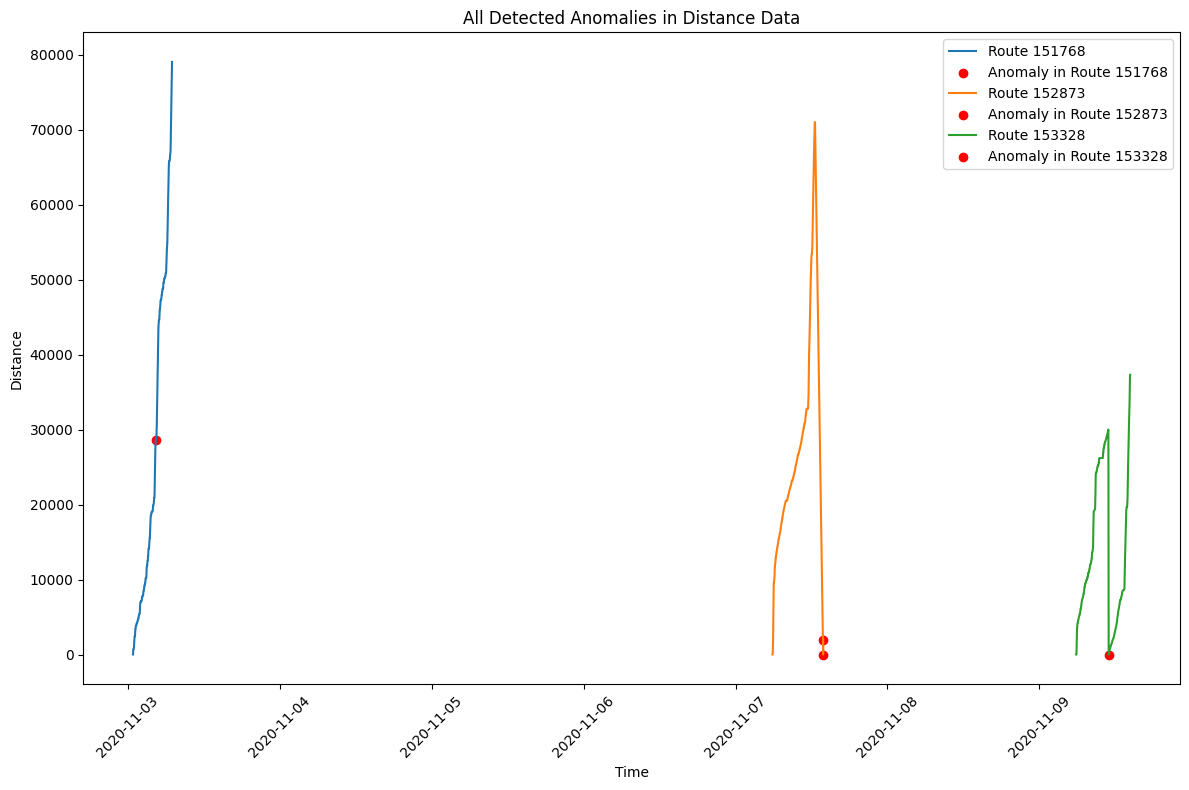

In [21]:

# All Anomalies Plot
plt.figure(figsize=(12, 8))
sample_routes = navigation_data[navigation_data['reset_flag']].route_id.unique()[:3]
for route_id in sample_routes:
    route_data = navigation_data[navigation_data['route_id'] == route_id]
    plt.plot(route_data['recorded_at'], route_data['distance'], label=f'Route {route_id}', linestyle='-')
    anomalies = route_data[route_data['any_anomaly']]
    plt.scatter(anomalies['recorded_at'], anomalies['distance'], color='red', label=f'Anomaly in Route {route_id}')
plt.title('All Detected Anomalies in Distance Data')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


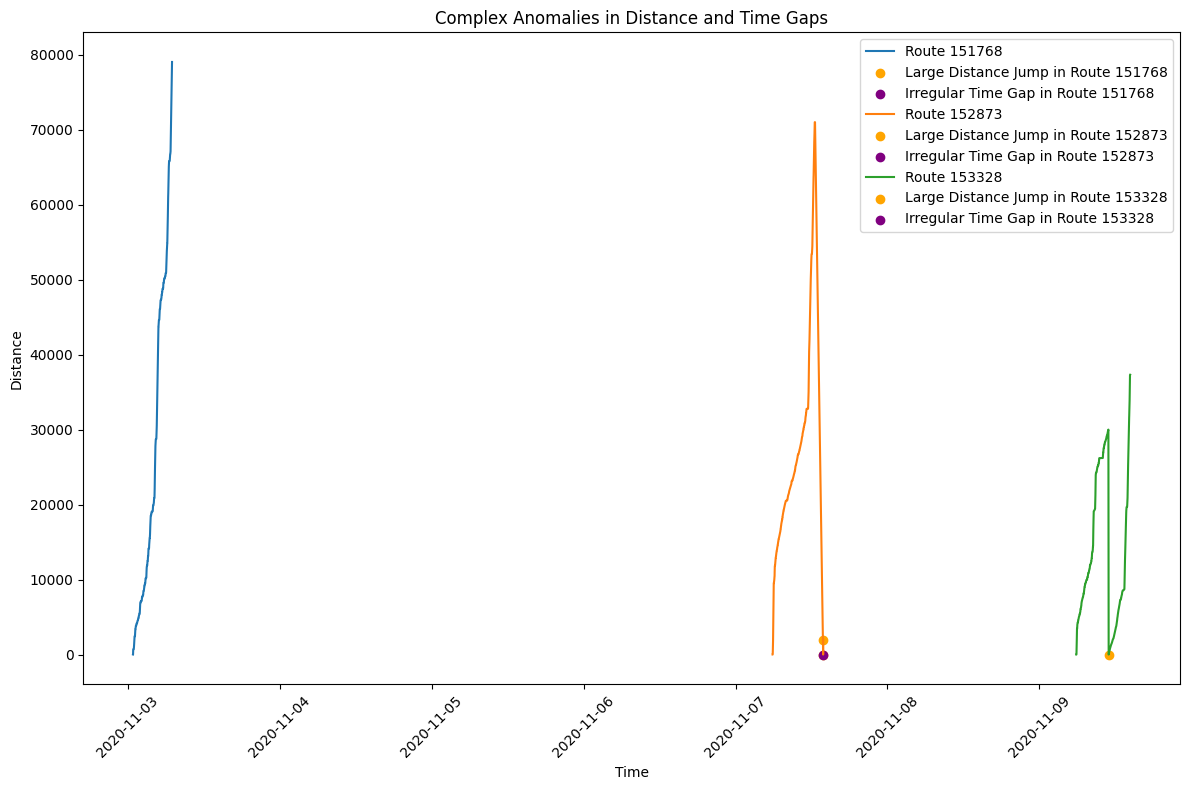

In [22]:

# Complex Anomalies Plot (Distance Jumps and Irregular Time Gaps)
plt.figure(figsize=(12, 8))
for route_id in sample_routes:
    route_data = navigation_data[navigation_data['route_id'] == route_id]
    plt.plot(route_data['recorded_at'], route_data['distance'], label=f'Route {route_id}', linestyle='-')
    jump_anomalies = route_data[route_data['distance_jump_anomaly']]
    plt.scatter(jump_anomalies['recorded_at'], jump_anomalies['distance'], color='orange', label=f'Large Distance Jump in Route {route_id}')
    gap_anomalies = route_data[route_data['time_gap_anomaly']]
    plt.scatter(gap_anomalies['recorded_at'], gap_anomalies['distance'], color='purple', label=f'Irregular Time Gap in Route {route_id}')
plt.title('Complex Anomalies in Distance and Time Gaps')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


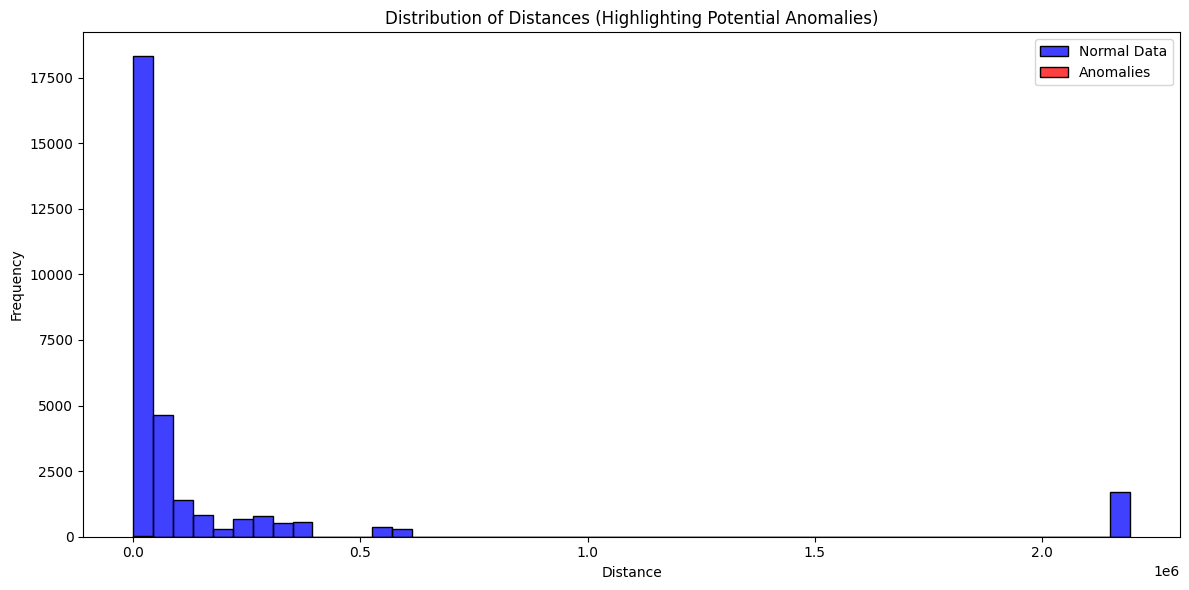

In [23]:

# Distance Distribution Plot
plt.figure(figsize=(12, 6))
sns.histplot(navigation_data['distance'], bins=50, color='blue', label='Normal Data')
sns.histplot(navigation_data[navigation_data['any_anomaly']]['distance'], bins=50, color='red', label='Anomalies')
plt.title('Distribution of Distances (Highlighting Potential Anomalies)')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


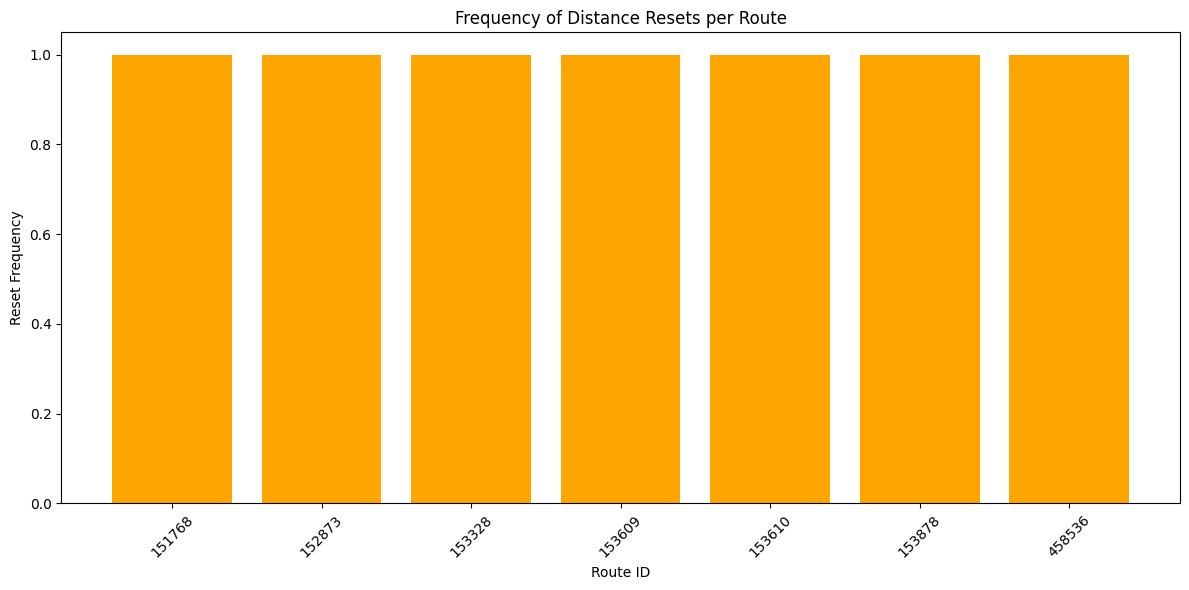

In [24]:

# Reset Frequency per Route Plot
reset_frequency = navigation_data[navigation_data['reset_flag']].groupby('route_id').size().reset_index(name='reset_count')
plt.figure(figsize=(12, 6))
plt.bar(reset_frequency['route_id'].astype(str), reset_frequency['reset_count'], color='orange')
plt.title('Frequency of Distance Resets per Route')
plt.xlabel('Route ID')
plt.ylabel('Reset Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
